In [1]:
import sys
sys.path.insert(1, '../../../../utils')
from pandas import read_csv, DataFrame
from dslabs_functions import *

from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart, plot_confusion_matrix, plot_multibar_chart


In [2]:
# Load data (already split into train/test)
train_filename = "../../data/prepared/balancing/flight_train_bal.csv"
test_filename = "../../data/prepared/balancing/flight_test_bal.csv"

input_train_data: DataFrame = read_csv(train_filename, na_values="")
input_test_data: DataFrame = read_csv(test_filename, na_values="")

target = "Cancelled"
file_tag = "flight"
metric = "recall"
lab_folder_fs = "lab3_preparation/feature_selection"

print(input_train_data.shape, input_test_data.shape)

(101544, 181) (22500, 182)


In [3]:
# Remove FlightDate
train_data = input_train_data.drop(columns=["FlightDate"], errors="ignore")
test_data = input_test_data.drop(columns=["FlightDate"], errors="ignore")

## Study and analyze feature selection methods

### Method 1: Low variance variables

In [4]:
# Identify low-variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, 0.08, target=target)
print("Variables to drop", vars2drop)

print(len(vars2drop), "variables to drop due to low variance")

# Print final variable list with for loop
final_vars = [col for col in train_data.columns if col not in vars2drop + [target]]
print("Final variables:")
for var in final_vars:
    print(var)

Variables to drop ['Airline_Air Wisconsin Airlines Corp', 'Airline_Alaska Airlines Inc.', 'Airline_Allegiant Air', 'Airline_Capital Cargo International', 'Airline_Comair Inc.', 'Airline_Commutair Aka Champlain Enterprises, Inc.', 'Airline_Endeavor Air Inc.', 'Airline_Envoy Air', 'Airline_Frontier Airlines Inc.', 'Airline_GoJet Airlines, LLC d/b/a United Express', 'Airline_Hawaiian Airlines Inc.', 'Airline_Horizon Air', 'Airline_JetBlue Airways', 'Airline_Mesa Airlines Inc.', 'Airline_Republic Airlines', 'Airline_Spirit Air Lines', 'Airline_United Air Lines Inc.', 'ArrTimeBlk_0', 'ArrTimeBlk_1', 'ArrTimeBlk_10', 'ArrTimeBlk_11', 'ArrTimeBlk_12', 'ArrTimeBlk_13', 'ArrTimeBlk_14', 'ArrTimeBlk_15', 'ArrTimeBlk_16', 'ArrTimeBlk_17', 'ArrTimeBlk_18', 'ArrTimeBlk_2', 'ArrTimeBlk_3', 'ArrTimeBlk_4', 'ArrTimeBlk_5', 'ArrTimeBlk_6', 'ArrTimeBlk_7', 'ArrTimeBlk_8', 'ArrTimeBlk_9', 'CRSArrTime', 'CRSDepTime', 'CRSElapsedTime', 'DOT_ID_Marketing_Airline', 'DepTimeBlk_0', 'DepTimeBlk_1', 'DepTimeBlk

In [5]:
# sample the train and test data for faster processing
sampled_train_data = train_data.sample(n=ceil(len(train_data) * 0.1), random_state=42)
print("Sampled train data shape:", sampled_train_data.shape)
sampled_test_data = test_data.sample(n=ceil(len(test_data) * 0.1), random_state=42)
print("Sampled test data shape:", sampled_test_data.shape)

Sampled train data shape: (10155, 181)
Sampled test data shape: (2250, 181)


In [6]:
CLASS_EVAL_METRICS: dict[str, Callable] = {
    "accuracy": accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "auc": roc_auc_score,
    "f1": f1_score,
}

DELTA_IMPROVE: float = 0.00001


def _score(metric_name: str, y_true, y_pred) -> float:
    """Consistent scoring across metrics."""
    try:
        if metric_name in ["recall", "precision", "f1"]:
            return CLASS_EVAL_METRICS[metric_name](y_true, y_pred, average="macro")
        return CLASS_EVAL_METRICS[metric_name](y_true, y_pred)
    except Exception:
        return 0.0


def run_KNN(trnX, trnY, tstX, tstY, metric: str = "accuracy") -> dict[str, float]:
    kvalues: list[int] = [1] + list(range(3, 10, 1))

    best_model = None
    best_performance: float = -1.0  # so metric=0 can still win

    eval: dict[str, float] = {}

    for k in kvalues:
        clf = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
        clf.fit(trnX, trnY)
        prdY: ndarray = clf.predict(tstX)

        performance = _score(metric, tstY, prdY)

        if performance - best_performance > DELTA_IMPROVE:
            best_performance = performance
            best_model = clf

    if best_model is not None:
        prd: ndarray = best_model.predict(tstX)

        for key in CLASS_EVAL_METRICS:
            eval[key] = _score(key, tstY, prd)

        eval["confusion_matrix"] = confusion_matrix(tstY, prd)

    return eval

def evaluate_approach_imported(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:

    # DO NOT mutate (no pop)
    trnY = train[target].values
    trnX: ndarray = train.drop(columns=[target]).values

    tstY = test[target].values
    tstX: ndarray = test.drop(columns=[target]).values

    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)

    # If either failed, return empty dict to skip
    if eval_NB == {} or eval_KNN == {}:
        return {}

    for met in CLASS_EVAL_METRICS:
        eval[met] = [eval_NB.get(met, 0.0), eval_KNN.get(met, 0.0)]

    eval["confusion_matrix"] = [eval_NB["confusion_matrix"], eval_KNN["confusion_matrix"]]
    return eval

def study_variance_for_feature_selection_imported(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1.0,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:

    # clean threshold grid
    n_steps = int(max_threshold / lag)
    options: list[float] = [round(i * lag, 3) for i in range(1, n_steps + 1)]

    results: dict[str, list] = {"NB": [], "KNN": []}

    # describe() returns numeric-only columns; drop target if present
    summary = train.describe()
    if target in summary.columns:
        summary = summary.drop(columns=[target])

    for thresh in options:
        vars2drop: Index[str] = summary.columns[(summary.loc["std"] ** 2) < thresh]

        keep_cols = [c for c in train.columns if c not in vars2drop]
        # make sure target is kept
        if target not in keep_cols:
            keep_cols.append(target)

        # how many predictors remain?
        n_features = len(keep_cols) - 1  # minus target
        if n_features <= 0:
            # append something so plot lengths match, then continue
            results["NB"].append(0.0)
            results["KNN"].append(0.0)
            continue

        train_copy = train[keep_cols].copy()
        test_copy = test[keep_cols].copy()

        eval = evaluate_approach_imported(train_copy, test_copy, target=target, metric=metric)
        if eval != {}:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])
        else:
            results["NB"].append(0.0)
            results["KNN"].append(0.0)

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )

    return results

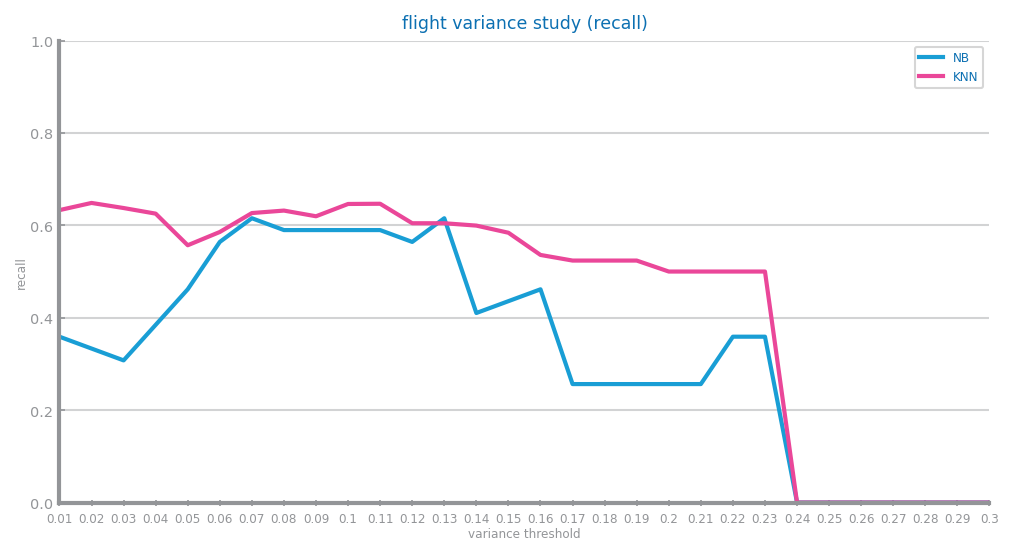

In [18]:
# Threshold analysis
figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection_imported(
    sampled_train_data,
    sampled_test_data,
    target=target,
    max_threshold=0.3,
    lag=0.01,
    metric=metric,
    file_tag=file_tag,
)
savefig(f"../../charts/lab3_preparation/feature_selection/low_variance_updated.png")
show()

[FS-LowVariance] Dropping 136 vars (threshold=0.08)
Train shape: (101544, 45) Test shape: (22500, 45)


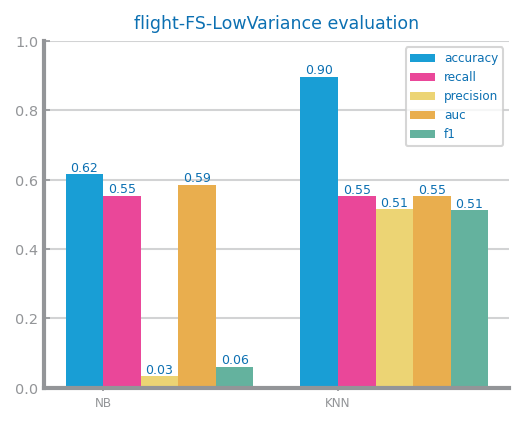

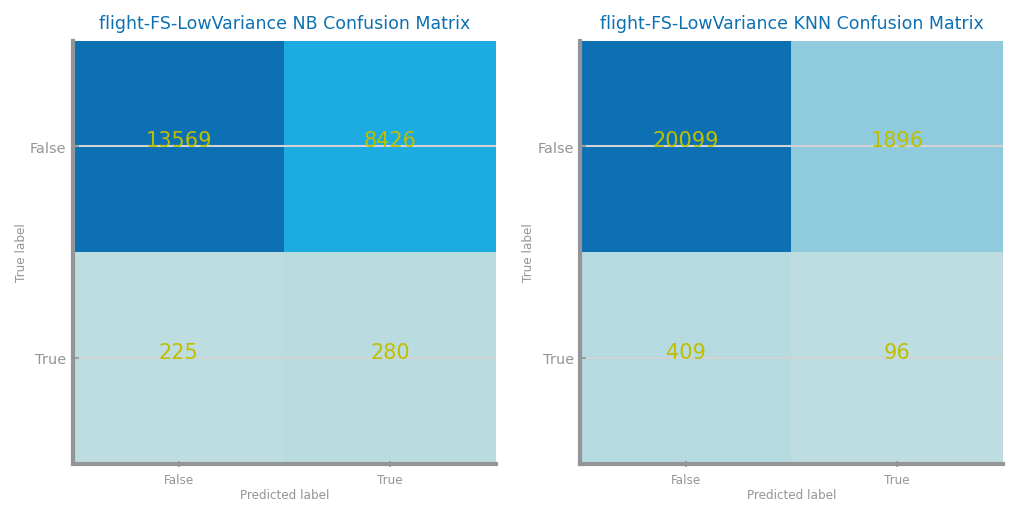

In [25]:
import os
from matplotlib.pyplot import figure, subplots, savefig, show

# -----------------------------
# Method 1 charts: Low Variance
# -----------------------------

approach_fs1 = "FS-LowVariance"
var_threshold = 0.08  # same threshold you already used

# 1) Select variables to drop (learn from TRAIN only)
vars2drop_lv: list[str] = select_low_variance_variables(train_data, var_threshold, target=target)

# 2) Apply to train and test (same dropped columns)
trn_fs1 = train_data.drop(columns=vars2drop_lv, errors="ignore").copy()
tst_fs1 = test_data.drop(columns=vars2drop_lv, errors="ignore").copy()

print(f"[{approach_fs1}] Dropping {len(vars2drop_lv)} vars (threshold={var_threshold})")
print("Train shape:", trn_fs1.shape, "Test shape:", tst_fs1.shape)

# 3) Evaluate NB vs KNN
eval_fs1: dict[str, list] = evaluate_approach_imported(trn_fs1.copy(), tst_fs1.copy(), target=target, metric=metric)

if eval_fs1 == {}:
    raise RuntimeError("Evaluation failed (empty eval dict). Check that trn_fs1/tst_fs1 have features and target.")

# 4) Save charts (match your scaling notebook style)
charts_dir = f"../../charts/{lab_folder_fs}"
os.makedirs(charts_dir, exist_ok=True)

# --- Performance multibar chart ---
figure()
eval_metrics_fs1 = {k: v for k, v in eval_fs1.items() if k != "confusion_matrix"}
plot_multibar_chart(
    ["NB", "KNN"],
    eval_metrics_fs1,
    title=f"{file_tag}-{approach_fs1} evaluation",
    percentage=True
)
savefig(f"../../charts/lab3_preparation/feature_selection/low_variance_nb_knn_eval.png")
show()

# --- Confusion matrices ---
fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))

# derive labels from the data you're evaluating
labels = trn_fs1[target].unique()
labels.sort()

plot_confusion_matrix(eval_fs1["confusion_matrix"][0], labels, ax=axs[0])
axs[0].set_title(f"{file_tag}-{approach_fs1} NB Confusion Matrix")

plot_confusion_matrix(eval_fs1["confusion_matrix"][1], labels, ax=axs[1])
axs[1].set_title(f"{file_tag}-{approach_fs1} KNN Confusion Matrix")

savefig(f"../../charts/lab3_preparation/feature_selection/low_variance_nb_knn_confusion_matrices.png")
show()


### Method 2: Redundant variables

In [20]:
# Local copy of select_redundant_variables with fixes
def select_redundant_variables(data: DataFrame, min_threshold: float = 0.8, target: str = "class") -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True, errors='ignore')
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop

In [21]:
# Identify redundant variables
vars2drop: list[str] = select_redundant_variables(train_data, target=target, min_threshold=0.5)
print("Variables to drop", vars2drop)

print(len(vars2drop), "variables to drop due to redundancy")

# Print final variable list with for loop
final_vars = [col for col in train_data.columns if col not in vars2drop + [target]]
print("Final variables:")
for var in final_vars:
    print(var)

Variables to drop ['IATA_Code_Operating_Airline_ZW', 'Operating_Airline_ZW', 'IATA_Code_Marketing_Airline_AS', 'IATA_Code_Operating_Airline_AS', 'Marketing_Airline_Network_AS', 'Operated_or_Branded_Code_Share_Partners_AS', 'Operating_Airline_AS', 'IATA_Code_Marketing_Airline_G4', 'IATA_Code_Operating_Airline_G4', 'Marketing_Airline_Network_G4', 'Operated_or_Branded_Code_Share_Partners_G4', 'Operating_Airline_G4', 'IATA_Code_Marketing_Airline_AA', 'IATA_Code_Operating_Airline_AA', 'Marketing_Airline_Network_AA', 'Operated_or_Branded_Code_Share_Partners_AA', 'Operating_Airline_AA', 'IATA_Code_Operating_Airline_PT', 'Operating_Airline_PT', 'IATA_Code_Operating_Airline_OH', 'Operating_Airline_OH', 'IATA_Code_Operating_Airline_C5', 'Operating_Airline_C5', 'IATA_Code_Marketing_Airline_DL', 'IATA_Code_Operating_Airline_DL', 'Marketing_Airline_Network_DL', 'Operated_or_Branded_Code_Share_Partners_DL', 'Operating_Airline_DL', 'IATA_Code_Operating_Airline_9E', 'Operated_or_Branded_Code_Share_Par

In [22]:
def study_redundancy_for_feature_selection_imported(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [round(min_threshold + i * lag, 3) for i in range(ceil((1 - min_threshold) / lag) + 1)]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True, errors="ignore")
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)

        eval = evaluate_approach_imported(train_copy, test_copy, target=target, metric=metric)

        if eval and metric in eval:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])
        else:
            results["NB"].append(0.0)
            results["KNN"].append(0.0)

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    return results

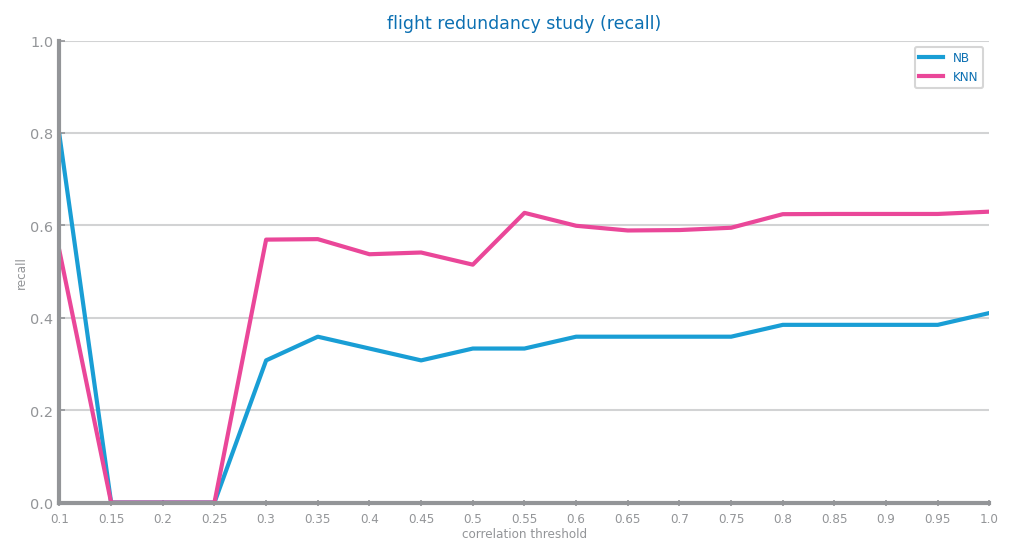

In [23]:
# Threshold analysis
figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection_imported(
    sampled_train_data,
    sampled_test_data,
    target=target,
    min_threshold=0.1,
    lag=0.05,
    metric=metric,
    file_tag=file_tag,
)
savefig(f"../../charts/lab3_preparation/feature_selection/redundancy_updated.png")
show()

In [12]:
# Safe local redundancy selector (renamed to avoid collision with dslabs_functions)
def select_redundant_variables_safe(
    data: DataFrame, min_threshold: float = 0.8, target: str = "class"
) -> list[str]:
    df = data.drop(columns=[target], errors="ignore")
    corr_matrix = df.corr().abs()
    variables = corr_matrix.columns

    vars2drop: list[str] = []
    for v1 in variables:
        vars_corr = corr_matrix[v1].loc[corr_matrix[v1] >= min_threshold]
        vars_corr = vars_corr.drop(labels=[v1], errors="ignore")
        if len(vars_corr) > 0:
            for v2 in vars_corr.index:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


[FS-Redundancy] Dropping 130 vars (corr_threshold=0.5)
Train shape: (101544, 51) Test shape: (22500, 51)


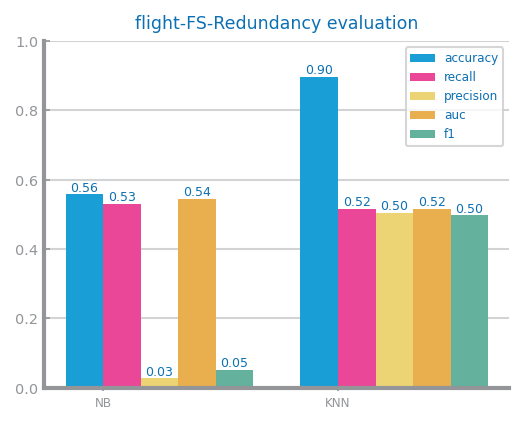

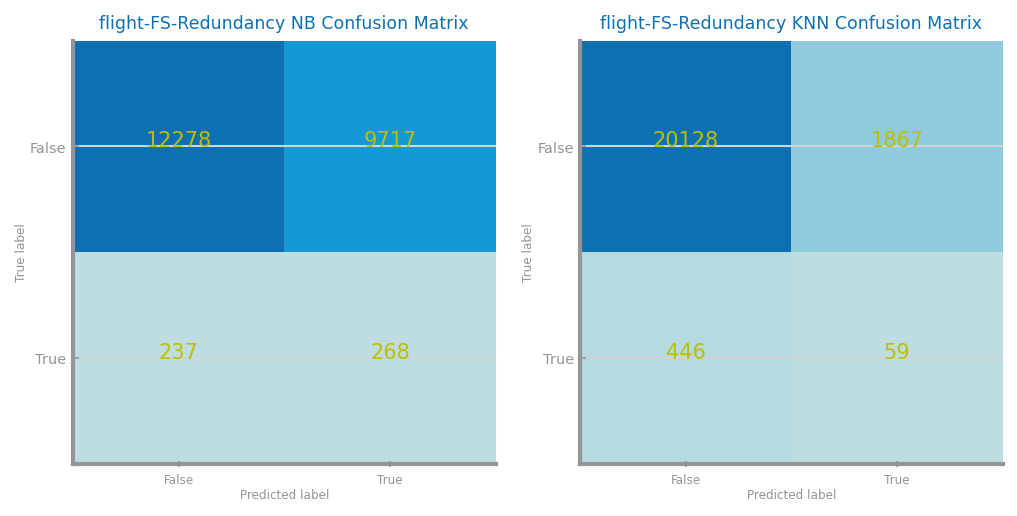

In [24]:
import os
from matplotlib.pyplot import figure, subplots, savefig, show

approach_fs2 = "FS-Redundancy"
corr_threshold = 0.5  # set from your redundancy study plot

# Use SAFE local selector (not the dslabs one)
vars2drop_red: list[str] = select_redundant_variables_safe(
    train_data, min_threshold=corr_threshold, target=target
)

trn_fs2 = train_data.drop(columns=vars2drop_red, errors="ignore").copy()
tst_fs2 = test_data.drop(columns=vars2drop_red, errors="ignore").copy()

print(f"[{approach_fs2}] Dropping {len(vars2drop_red)} vars (corr_threshold={corr_threshold})")
print("Train shape:", trn_fs2.shape, "Test shape:", tst_fs2.shape)

# Safety check
n_features_fs2 = trn_fs2.shape[1] - 1
if n_features_fs2 <= 0:
    raise RuntimeError(
        f"{approach_fs2} produced 0 features (only target left). "
        f"Increase corr_threshold (e.g., 0.7+) or adjust redundancy logic."
    )

eval_fs2: dict[str, list] = evaluate_approach_imported(
    trn_fs2.copy(), tst_fs2.copy(), target=target, metric=metric
)

if eval_fs2 == {}:
    raise RuntimeError("Evaluation failed (empty eval dict). Check features/target after redundancy drop.")

charts_dir = f"../../charts/{lab_folder_fs}"
os.makedirs(charts_dir, exist_ok=True)

# Performance plot
figure()
eval_metrics_fs2 = {k: v for k, v in eval_fs2.items() if k != "confusion_matrix"}
plot_multibar_chart(
    ["NB", "KNN"], eval_metrics_fs2, title=f"{file_tag}-{approach_fs2} evaluation", percentage=True
)
savefig(f"../../charts/lab3_preparation/feature_selection/redundancy_nb_knn_eval.png")
show()

# Confusion matrices
fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
labels = trn_fs2[target].unique()
labels.sort()

plot_confusion_matrix(eval_fs2["confusion_matrix"][0], labels, ax=axs[0])
axs[0].set_title(f"{file_tag}-{approach_fs2} NB Confusion Matrix")

plot_confusion_matrix(eval_fs2["confusion_matrix"][1], labels, ax=axs[1])
axs[1].set_title(f"{file_tag}-{approach_fs2} KNN Confusion Matrix")

savefig(f"../../charts/lab3_preparation/feature_selection/redundancy_nb_knn_confusion_matrices.png")
show()


## Apply feature selection

In [27]:
# Local copy of apply_feature_selection without CSV saving
def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    return train_copy, test_copy

### Low variance selection

In [ ]:
# Save copies of train/test after removing low variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.4, target=target)
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_lv.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_lv.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

### Redundant variable selection

In [ ]:
# Save copies of train/test after removing low variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.6, target=target)
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_red.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_red.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

### Apply both

In [14]:
# Save copies of train/test after removing low variance variables
lv_vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.6, target=target)
red_vars2drop: list[str] = select_redundant_variables(train_data, min_threshold=0.5, target=target)

# Concatinate and remove duplicates
vars2drop: list[str] = list(set(lv_vars2drop + red_vars2drop))
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_both.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_both.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Saving feature selected TRAIN to: ../../data/prepared/feature-selection/flight_train_fs_both.csv
Saving feature selected TEST  to: ../../data/prepared/feature-selection/flight_test_fs_both.csv
Original data: train=(140000, 181), test=(60000, 181)
After low variance FS: train_cp=(140000, 45), test_cp=(60000, 45)
